# Import

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader, Dataset
from torch.utils.data import random_split
from torchvision.utils import make_grid
from skimage import io

import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from typing import Tuple, NoReturn
import seaborn as sns
import time
import pandas as pd
from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataloader

In [3]:
class PetsDataset(Dataset):
    #CLASS-ID 1-37 different breeds 
    def __init__(self,image_dir: str,annotation_dir: str, train: bool,transform):
        super().__init__()

        if train:
            self.data = pd.read_csv(os.path.join(annotation_dir,"trainval.txt"),delimiter=" ")
        else:
            self.data = pd.read_csv(os.path.join(
                annotation_dir, "test.txt"), delimiter=" ")
        
        self.image_dir = image_dir
        self.transform = transform


        
    def __len__(self):

        return self.data.shape[0]
    
    def __getitem__(self,idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()
 
        image_pth = os.path.join(self.image_dir,self.data.iloc[idx,0]+ ".jpg")
        
        image = Image.open(image_pth).convert("RGB")
     
        label = self.data.iloc[idx,1] - 1

        
        if self.transform:

            image = self.transform(image)

        
        return image,label

In [4]:
#Transformations

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

#Initialise Dataset
pets_dataset = PetsDataset(image_dir="data/images/",annotation_dir="data/annotations/",train=True,transform=transform)
pets_dataset_train,pets_dataset_val = torch.utils.data.random_split(pets_dataset,[3000,679])
pets_dataset_test =  PetsDataset(image_dir="data/images/",annotation_dir="data/annotations/",train=False,transform=transform)

In [5]:
BATCH_SIZE = 8
NUM_WORKERS = 8
SHUFFLE = True

#Dataloader
train_loader = DataLoader(pets_dataset_train,batch_size=BATCH_SIZE,shuffle=SHUFFLE)
test_loader = DataLoader(pets_dataset_test,batch_size=BATCH_SIZE,shuffle=SHUFFLE)
val_loader = DataLoader(pets_dataset_val,batch_size=BATCH_SIZE,shuffle=SHUFFLE)

## Visualizing Data

In [6]:
label_dict = {1: 'abyssinian',
              2: 'american_bulldog',
              3: 'american_pit_bull_terrier',
              4: 'basset_hound',
              5: 'beagle',
              6: 'bengal',
              7: 'birman',
              8: 'bombay',
              9: 'boxer',
              10: 'british_shorthair',
              11: 'chihuahua',
              12: 'egyptian_mau',
              13: 'english_cocker_spaniel',
              14: 'english_setter',
              15: 'german_shorthaired',
              16: 'great_pyrenees',
              17: 'havanese',
              18: 'japanese_chin',
              19: 'keeshond',
              20: 'leonberger',
              21: 'maine_coon',
              22: 'miniature_pinscher',
              23: 'newfoundland',
              24: 'persian',
              25: 'pomeranian',
              26: 'pug',
              27: 'ragdoll',
              28: 'russian_blue',
              29: 'saint_bernard',
              30: 'samoyed',
              31: 'scottish_terrier',
              32: 'shiba_inu',
              33: 'siamese',
              34: 'sphynx',
              35: 'staffordshire_bull',
              36: 'wheaten_terrier',
              37: 'yorkshire_terrier'
              }


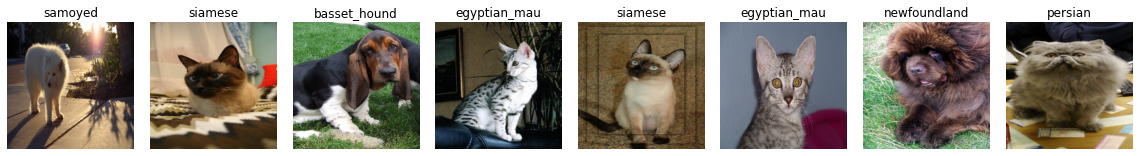

In [7]:
def show_grid(data, titles=None):
    """Imshow for Tensor."""
    data = data.numpy().transpose((0, 2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    data = std * data + mean
    data = np.clip(data, 0, 1)

    plt.figure(figsize=(8*2, 4*2))
    for i in range(8):
        plt.subplot(4, 8, i+1)
        plt.imshow(data[i])
        plt.axis("off")
        if titles is not None:
            plt.title(titles[i])
    plt.tight_layout()
    plt.show()


# Get a batch of training data and displaying it
image,label = next(iter(train_loader))



titles = [label_dict[x.item()+1] for x in label]

show_grid(image, titles=titles)


# Main Code

In [8]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    """ Training a model for one epoch """
    
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device).long()
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
    mean_loss = np.mean(loss_list)
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device):
    """ Evaluating the model for either validation or test """
    correct = 0
    total = 0
    loss_list = []
    count = 0
    for images, labels in eval_loader:
        images = images.to(device)
        labels = labels.to(device).long()
        
        # Forward pass only to get logits/output
        outputs = model(images)
                 
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
            
        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        
        correct += len( torch.where(preds==labels)[0] )
        total += len(labels)
        count+=1
          
    # Total correct predictions and loss
    accuracy = (correct / len(eval_loader.dataset)) * 100
    
    loss = np.mean(loss_list)
    
    return accuracy, loss


def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    loss_iters = []
    valid_acc = []
    
    for epoch in range(num_epochs):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        accuracy, loss = eval_model(
                    model=model, eval_loader=valid_loader,
                    criterion=criterion, device=device
            )
        valid_acc.append(accuracy)
        val_loss.append(loss)
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, device=device
            )
            
        if scheduler is not None:

            scheduler.step()
        
        train_loss.append(mean_loss)
        loss_iters = loss_iters + cur_loss_iters
        
        if(epoch % 5 == 0 or epoch==num_epochs-1):
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Valid loss: {round(loss, 5)}")
            print(f"    Accuracy: {accuracy} %")
            print("\n")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters, valid_acc

In [9]:
def save_model(model, optimizer, epoch, stats):
    """ Saving model checkpoint """

    if(not os.path.exists("models")):
        os.makedirs("models")
    savepath = f"models/checkpoint_epoch_{epoch}.pth"

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, savepath)
    return


def load_model(model, optimizer, savepath):
    """ Loading pretrained checkpoint """

    checkpoint = torch.load(savepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]

    return model, optimizer, epoch, stats


def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]]
                       )  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f


def set_random_seed(random_seed=None):
    """
    Using random seed for numpy and torch
    """
    if(random_seed is None):
        random_seed = 13
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    return

# Loading Model 

In [10]:
set_random_seed()

In [11]:
#Loading Pretrained Network
model = torchvision.models.resnet101(pretrained=True)

#Modifying the last layer of the Network
in_features_fc = model.fc.in_features
model.fc = nn.Linear(in_features_fc,37)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)


#Learning rate scheduling
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,0.1)

# Training and Evaluation

In [13]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
    model=model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
    train_loader=train_loader, valid_loader=val_loader, num_epochs=50
)


  0%|          | 1/375 [00:00<01:04,  5.81it/s]

85


100%|██████████| 375/375 [01:02<00:00,  5.99it/s]


Epoch 1/50
    Train loss: 2.17363
    Valid loss: 3.69891
    Accuracy: 0.016200294550810016%




  0%|          | 1/375 [00:00<01:03,  5.92it/s]

85


 57%|█████▋    | 213/375 [00:34<00:29,  5.55it/s]